# Chapter 5
## Auxiliary
## Read Temp Time Series

The aim of this section is to get temperature data from German Weather Agency (DWD).

In [1]:
import datetime as dt
import os
import ftplib
import pandas as pd
import geopandas as gpd

## FTP Connection

### Connection Parameters

In [2]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [43]:
# The topic of interest. 
# https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/
topic_dir = "daily/kl/recent/" # recent and historical

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [44]:
local_ftp_dir         = "../data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "../data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [45]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

../data/original/DWD/
../data/original/DWD/daily/kl/recent/
../data/original/DWD/daily/kl/recent/

../data/generated/DWD/
../data/generated/DWD/daily/kl/recent/
../data/generated/DWD/daily/kl/recent/
../data/generated/DWD/daily/kl/recent/


In [46]:

os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [47]:

ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [48]:
ret = ftp.cwd(".")

In [49]:
#ftp.quit()

### FTP Grab File Function

In [50]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [51]:


def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [52]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [53]:
df_ftpdir.tail(10)

,station_id,name,ext,size,type
579,15520,tageswerte_KL_15520_akt.zip,.zip,9587,-
580,15547,tageswerte_KL_15547_akt.zip,.zip,9576,-
581,15555,tageswerte_KL_15555_akt.zip,.zip,28667,-
582,15801,tageswerte_KL_15801_akt.zip,.zip,9435,-
583,15813,tageswerte_KL_15813_akt.zip,.zip,22774,-
584,15911,tageswerte_KL_15911_akt.zip,.zip,8680,-
585,15976,tageswerte_KL_15976_akt.zip,.zip,11168,-
586,15978,tageswerte_KL_15978_akt.zip,.zip,9515,-
587,19171,tageswerte_KL_19171_akt.zip,.zip,28844,-
588,19172,tageswerte_KL_19172_akt.zip,.zip,21640,-


### Dataframe with Temp Zip Files

In [54]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.tail(10)

,name,ext,size,type
station_id,,,,
15520,tageswerte_KL_15520_akt.zip,.zip,9587,-
15547,tageswerte_KL_15547_akt.zip,.zip,9576,-
15555,tageswerte_KL_15555_akt.zip,.zip,28667,-
15801,tageswerte_KL_15801_akt.zip,.zip,9435,-
15813,tageswerte_KL_15813_akt.zip,.zip,22774,-
15911,tageswerte_KL_15911_akt.zip,.zip,8680,-
15976,tageswerte_KL_15976_akt.zip,.zip,11168,-
15978,tageswerte_KL_15978_akt.zip,.zip,9515,-
19171,tageswerte_KL_19171_akt.zip,.zip,28844,-


### Download the Station Description File

In [55]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

KL_Tageswerte_Beschreibung_Stationen.txt


In [56]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate/daily/kl/recent/KL_Tageswerte_Beschreibung_Stationen.txt
To:   ../data/original/DWD/daily/kl/recent/KL_Tageswerte_Beschreibung_Stationen.txt


In [57]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf8")#"utf8", iso8859_2
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en,encoding='iso8859_2', parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [58]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")


df_stations['date_from']=pd.to_datetime(df_stations['date_from'],infer_datetime_format=True) 
df_stations['date_to']=pd.to_datetime(df_stations['date_to'],infer_datetime_format=True)
df_stations.tail()

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
19317,1974-01-01,1981-06-30,486,48.2333,11.5667,Oberschleißheim/Flugplatz,Bayern
19318,1946-11-01,1978-12-31,292,50.7180,10.4310,Schmalkalden,Thüringen
19364,1937-12-01,1944-12-31,720,50.6167,10.8167,Schmiedefeld/Rennsteig,Thüringen
19378,1958-01-01,1977-12-31,505,50.8333,10.5833,Finsterbergen,Thüringen
19433,1938-04-01,1945-02-28,316,50.8188,10.3443,"Liebenstein, Bad",Thüringen


### Select Stations Located in NRW from Station Description Dataframe

In [59]:
temp_s_df=gpd.read_file('../data/generated/DWD/hourly/air_temperature/historical/Temp_df_stations_cologne.geojson', index_col='station_id')\
.set_crs(4326, allow_override=True).to_crs(5676).set_index('station_id')
temp_s_df

,date_from,date_to,altitude,latitude,longitude,name,state,field_9,ID_0,ISO,...,NAME_1,ID_2,NAME_2,ID_3,NAME_3,TYPE_3,ENGTYPE_3,NL_NAME_3,VARNAME_3,geometry
station_id,,,,,,,,,,,,,,,,,,,,,
2667,1960-01-01,2022-03-01,92,50.8646,7.1575,Köln-Bonn,Nordrhein-Westfalen,None,86,DEU,...,Nordrhein-Westfalen,29,Köln,289,Cologne Städte,Kreisfreie Städte,Urban district,None,Koln,MULTIPOINT (2581532.425 5637222.637)
2968,2008-12-01,2022-03-01,43,50.9894,6.9777,Köln-Stammheim,Nordrhein-Westfalen,None,86,DEU,...,Nordrhein-Westfalen,29,Köln,289,Cologne Städte,Kreisfreie Städte,Urban district,None,Koln,MULTIPOINT (2568690.662 5650922.640)


In [60]:
df_zips.tail()

,name,ext,size,type
station_id,,,,
15911,tageswerte_KL_15911_akt.zip,.zip,8680,-
15976,tageswerte_KL_15976_akt.zip,.zip,11168,-
15978,tageswerte_KL_15978_akt.zip,.zip,9515,-
19171,tageswerte_KL_19171_akt.zip,.zip,28844,-
19172,tageswerte_KL_19172_akt.zip,.zip,21640,-


In [61]:
#print(dfNRW.index)
station_ids_selected = list(temp_s_df.index)
set(station_ids_selected).issubset(set(df_zips)) # we have some missing stations

False

### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [62]:
# Add the names of the zip files only to a list. 
local_zip_list = []

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        #print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)

### Concat the Temp Time Series dfs




In [63]:
# column names
#STATIONS_ID;MESS_DATUM;QN_9;TT_TU;RF_TU;eor

In [64]:
import datetime as dt

In [65]:
def temp_ts_to_df(fname):
    
    df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2")
   
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    print(df.columns)
    df['mess_datum']=pd.to_datetime(df['mess_datum'], format='%Y%m%d', utc=True, errors='ignore')
    #begin_date=dt.datetime.strptime('01-08-2019',"%d-%m-%Y")
    begin_date=dt.datetime(2019, 8, 1, 0, 0, 0, tzinfo=dt.timezone.utc)
    df=df[df['mess_datum']>begin_date]

    return(df)

In [66]:
from zipfile import ZipFile

In [67]:

def ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                df = pd.concat([df, dftmp])

    
    return(df)

In [68]:
df_merged_ts = ts_merge()

Zip archive: ../data/original/DWD/daily/kl/recent/tageswerte_KL_02667_akt.zip
Extract product file: produkt_klima_tag_20210109_20220712_02667.txt

Index(['stations_id', 'mess_datum', 'qn_3', 'fx', 'fm', 'qn_4', 'rsk', 'rskf',
       'sdk', 'shk_tag', 'nm', 'vpm', 'pm', 'tmk', 'upm', 'txk', 'tnk', 'tgk',
       'eor'],
      dtype='object')
Zip archive: ../data/original/DWD/daily/kl/recent/tageswerte_KL_02968_akt.zip
Extract product file: produkt_klima_tag_20210109_20220712_02968.txt

Index(['stations_id', 'mess_datum', 'qn_3', 'fx', 'fm', 'qn_4', 'rsk', 'rskf',
       'sdk', 'shk_tag', 'nm', 'vpm', 'pm', 'tmk', 'upm', 'txk', 'tnk', 'tgk',
       'eor'],
      dtype='object')


/var/folders/bs/8_rscwxd25z1bcq4d89vsz380000gn/T/ipykernel_14524/2110297448.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/bs/8_rscwxd25z1bcq4d89vsz380000gn/T/ipykernel_14524/2110297448.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
/var/folders/bs/8_rscwxd25z1bcq4d89vsz380000gn/T/ipykernel_14524/2110297448.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single characte

### Description

https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/recent/DESCRIPTION_obsgermany_climate_daily_kl_recent_en.pdf
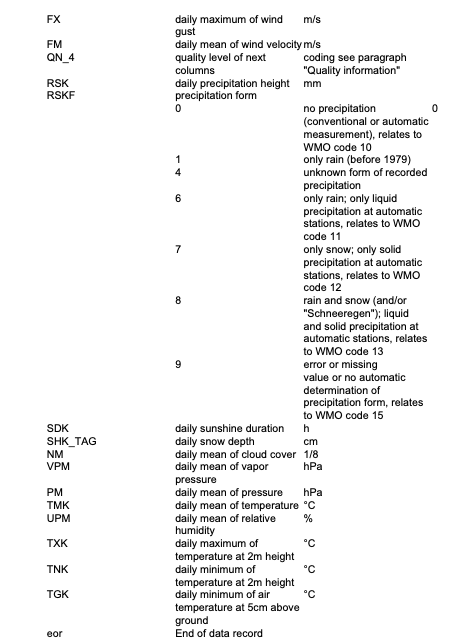

In [69]:
df_merged_ts['mess_datum']=pd.to_datetime(df_merged_ts['mess_datum'], format='%Y%m%d', utc=True, errors='ignore')
df_merged_ts.head()

,stations_id,mess_datum,qn_3,fx,fm,qn_4,rsk,rskf,sdk,shk_tag,nm,vpm,pm,tmk,upm,txk,tnk,tgk,eor
0,2667,2021-01-09 00:00:00+00:00,10,3.6,1.0,3,1.2,8,0.00,1,7.8,6.3,1011.25,0.8,96.79,2.1,-0.8,-1.7,eor
1,2667,2021-01-10 00:00:00+00:00,10,3.6,1.3,3,0.0,6,0.00,0,5.9,6.2,1012.63,0.9,94.75,3.1,-2.0,-4.0,eor
2,2667,2021-01-11 00:00:00+00:00,10,9.6,3.4,3,7.6,6,0.15,0,7.2,5.4,1008.02,0.6,84.00,3.6,-2.2,-3.4,eor
3,2667,2021-01-12 00:00:00+00:00,10,16.1,5.0,3,6.8,8,0.00,0,6.5,7.2,998.07,3.9,88.83,7.2,-0.3,-3.3,eor
4,2667,2021-01-13 00:00:00+00:00,10,12.2,3.5,3,0.0,6,0.40,0,6.0,6.2,1004.15,2.4,85.46,4.5,-0.3,-2.2,eor


In [70]:
df_merged_ts.shape

(1100, 19)

In [71]:
df_stations.head(2)

,date_from,date_to,altitude,latitude,longitude,name,state
station_id,,,,,,,
1,1937-01-01,1986-06-30,478,47.8413,8.8493,Aach,Baden-Württemberg
3,1891-01-01,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen


In [72]:
df_merged_ts.to_csv(local_ts_merged_dir + "ts_merged.csv",sep=";")

In [73]:
df_merged_ts.head()

,stations_id,mess_datum,qn_3,fx,fm,qn_4,rsk,rskf,sdk,shk_tag,nm,vpm,pm,tmk,upm,txk,tnk,tgk,eor
0,2667,2021-01-09 00:00:00+00:00,10,3.6,1.0,3,1.2,8,0.00,1,7.8,6.3,1011.25,0.8,96.79,2.1,-0.8,-1.7,eor
1,2667,2021-01-10 00:00:00+00:00,10,3.6,1.3,3,0.0,6,0.00,0,5.9,6.2,1012.63,0.9,94.75,3.1,-2.0,-4.0,eor
2,2667,2021-01-11 00:00:00+00:00,10,9.6,3.4,3,7.6,6,0.15,0,7.2,5.4,1008.02,0.6,84.00,3.6,-2.2,-3.4,eor
3,2667,2021-01-12 00:00:00+00:00,10,16.1,5.0,3,6.8,8,0.00,0,6.5,7.2,998.07,3.9,88.83,7.2,-0.3,-3.3,eor
4,2667,2021-01-13 00:00:00+00:00,10,12.2,3.5,3,0.0,6,0.40,0,6.0,6.2,1004.15,2.4,85.46,4.5,-0.3,-2.2,eor


In [74]:
 df_merged_ts['mess_datum'].min(),  df_merged_ts['mess_datum'].max()

(Timestamp('2021-01-09 00:00:00+0000', tz='UTC'),
 Timestamp('2022-07-12 00:00:00+0000', tz='UTC'))

In [75]:
df_merged_ts.shape

(1100, 19)

In [76]:
df=df_merged_ts.groupby('mess_datum').mean()
df

,stations_id,qn_3,fx,fm,qn_4,rsk,rskf,sdk,shk_tag,nm,vpm,pm,tmk,upm,txk,tnk,tgk
mess_datum,,,,,,,,,,,,,,,,,
2021-01-09 00:00:00+00:00,2817.5,-494.5,-497.70,-499.00,3.0,1.30,6.0,-499.5000,-499.0,-495.60,6.35,6.125,1.10,95.540,2.10,-0.35,-1.05
2021-01-10 00:00:00+00:00,2817.5,-494.5,-497.70,-498.85,3.0,0.00,3.0,-499.5000,-499.5,-496.55,6.25,6.815,1.30,93.145,3.40,-0.90,-2.60
2021-01-11 00:00:00+00:00,2817.5,-494.5,-494.70,-497.80,3.0,5.30,5.0,-499.4250,-499.5,-495.90,5.55,4.510,1.30,82.315,4.45,-1.40,-2.70
2021-01-12 00:00:00+00:00,2817.5,-494.5,-491.45,-497.00,3.0,5.50,6.0,-499.5000,-499.5,-496.25,7.45,-0.465,4.55,87.480,7.35,0.45,-2.05
2021-01-13 00:00:00+00:00,2817.5,-494.5,-493.40,-497.75,3.0,0.00,3.0,-499.3000,-499.5,-496.50,6.30,2.575,2.80,84.710,4.85,0.35,-1.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-08 00:00:00+00:00,2817.5,-499.0,-495.20,-497.85,1.0,0.00,0.0,-495.8585,-999.0,-496.40,12.90,9.735,18.45,61.460,24.25,13.60,12.70
2022-07-09 00:00:00+00:00,2817.5,-499.0,-494.35,-497.70,1.0,0.25,3.0,-496.7165,-999.0,-496.00,14.60,7.920,19.10,67.460,25.35,13.60,12.15
2022-07-10 00:00:00+00:00,2817.5,-499.0,-494.85,-498.15,1.0,0.00,3.0,-498.6585,-999.0,-495.75,13.35,7.450,16.00,73.585,18.95,11.45,9.40


### Missing values

In [77]:
# create a bin including empty days between the range of earliest and latest day that a transaction took place
bins=pd.date_range(start= df_merged_ts['mess_datum'].min(), end=df_merged_ts['mess_datum'].max())
bins=pd.to_datetime(bins)
bins=pd.Series(bins)
bins=pd.DataFrame(bins, columns=['date'])
#bins['date']




In [78]:
# add this bin as an index into df with merge operation
# now, we have all days in the df


df1=pd.merge(bins,df, how='left', left_on=bins['date'], \
                 right_index=True).set_index('date')

#df1

In [79]:
df1.isna().any()

stations_id    False
qn_3           False
fx             False
fm             False
qn_4           False
rsk            False
rskf           False
sdk            False
shk_tag        False
nm             False
vpm            False
pm             False
tmk            False
upm            False
txk            False
tnk            False
tgk            False
dtype: bool

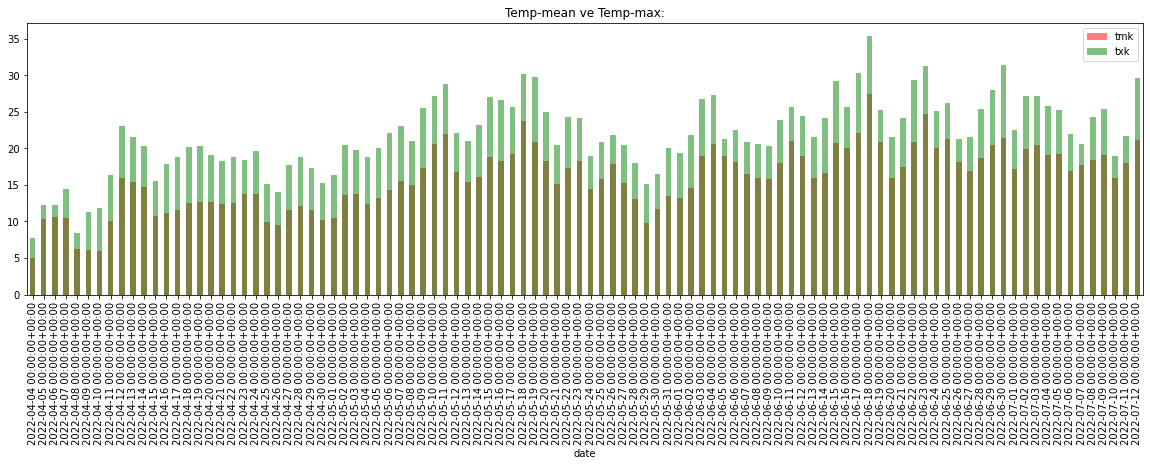

In [80]:
# plot
import matplotlib.pyplot as plt 
plt.figure(figsize=(20, 5))
plt.title(('Temp-mean ve Temp-max:'))
df1['tmk'].tail(100).plot.bar(color='Red', legend=True,  alpha=0.5)
df1['txk'].tail(100).plot.bar(color='green', legend=True, alpha=0.5)

plt.yticks()
plt.show()

In [81]:
df1[['tmk','txk']].corr()

,tmk,txk
tmk,1.000000,0.972291
txk,0.972291,1.000000
